In [3]:
from functools import partial, reduce

import pandas as pd
import pygam
from pygam.terms import s, f
import numpy as np
from plotnine import (
    ggplot,
    aes,
    geom_line,
    geom_ribbon,
    theme_bw,
    theme,
    theme_matplotlib,
    facet_wrap,
    geom_hline,
)
from matplotlib import pyplot as plt
from bayes_opt import BayesianOptimization

from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.read_csv("../data/prepared_data.csv", index_col="SEQN").rename(
    {"any_caffeine.1": "any_caffeine_log"}, axis=1
)

df.columns = [c.split("__")[-1] for c in df.columns]
# df["any_vig_activity"] = df["activity_vig_min"] >= 10
df.head()


,bmi_total,demo_age,activity_sed_min,alcohol_nmbr_drinks,poverty_num,activity_vig_min,activity_mod_min,smoking_cigs_pd,occ_hours_worked,any_caffeine,is_male,any_caffeine_log,demo_race_str_asian_non_hisp,demo_race_str_black,demo_race_str_hispanic_other,demo_race_str_mexican_american,demo_race_str_other_or_multi,kidney_had_stones,kidney_passed_stone,kidney_weak_failing
SEQN,,,,,,,,,,,,,,,,,,,,
109266,37.80,29.0,480.0,1.0,5.00,60.0,30.0,0.0,40.0,25.0,False,3.258097,1.0,0.0,0.0,0.0,0.0,False,False,False
109267,22.68,21.0,540.0,2.0,5.00,90.0,0.0,0.0,40.0,0.0,False,0.000000,0.0,0.0,1.0,0.0,0.0,False,False,False
109268,21.94,18.0,540.0,2.0,1.19,0.0,0.0,0.0,40.0,0.0,False,0.000000,0.0,0.0,0.0,0.0,0.0,False,False,False
109271,29.70,49.0,60.0,2.0,1.20,0.0,0.0,20.0,40.0,2087.5,True,7.644201,0.0,0.0,0.0,0.0,0.0,False,False,False
109273,21.90,36.0,180.0,2.0,0.53,0.0,120.0,15.0,28.0,21.5,True,3.113515,0.0,0.0,0.0,0.0,0.0,False,False,False


In [5]:
df.describe()

,bmi_total,demo_age,activity_sed_min,alcohol_nmbr_drinks,poverty_num,activity_vig_min,activity_mod_min,smoking_cigs_pd,occ_hours_worked,any_caffeine,any_caffeine_log,demo_race_str_asian_non_hisp,demo_race_str_black,demo_race_str_hispanic_other,demo_race_str_mexican_american,demo_race_str_other_or_multi
count,9693.000000,9693.000000,9.693000e+03,9693.000000,9.693000e+03,9693.000000,9693.000000,9693.000000,9693.000000,9693.000000,9693.000000,9693.000000,9693.000000,9693.000000,9693.000000,9693.000000
mean,29.880829,49.591974,3.348209e+02,2.317755,2.278618e+00,19.041989,25.847725,1.832456,39.745383,108.773290,3.244831,0.120912,0.263592,0.102239,0.116682,0.048901
std,7.325851,18.607845,2.024026e+02,1.656081,1.388301e+00,42.722724,49.341467,5.313004,10.417262,168.500569,2.216095,0.326042,0.440603,0.302978,0.321058,0.215673
min,14.200000,18.000000,5.397605e-79,1.000000,5.397605e-79,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,33.000000,1.800000e+02,2.000000,1.280000e+00,0.000000,0.000000,0.000000,40.000000,0.500000,0.405465,0.000000,0.000000,0.000000,0.000000,0.000000
50%,28.700000,50.000000,3.000000e+02,2.000000,1.950000e+00,0.000000,0.000000,0.000000,40.000000,58.000000,4.077537,0.000000,0.000000,0.000000,0.000000,0.000000
75%,33.400000,64.000000,4.800000e+02,2.000000,2.960000e+00,0.000000,30.000000,0.000000,40.000000,155.000000,5.049856,0.000000,1.000000,0.000000,0.000000,0.000000
max,92.300000,80.000000,1.320000e+03,15.000000,5.000000e+00,480.000000,600.000000,95.000000,80.000000,4680.000000,8.451267,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df.columns

Index(['bmi_total', 'demo_age', 'activity_sed_min', 'alcohol_nmbr_drinks',
       'poverty_num', 'activity_vig_min', 'activity_mod_min',
       'smoking_cigs_pd', 'occ_hours_worked', 'any_caffeine', 'is_male',
       'any_caffeine_log', 'demo_race_str_asian_non_hisp',
       'demo_race_str_black', 'demo_race_str_hispanic_other',
       'demo_race_str_mexican_american', 'demo_race_str_other_or_multi',
       'kidney_had_stones', 'kidney_passed_stone', 'kidney_weak_failing'],
      dtype='object')

## Fitting Guide

To fit the spline model, you have to keep track of both the index of the value in the dataframe and what type of spline
you want to fit. For that reason, I have created mapping of columns to spline formats, and then when the actual
model is being constructed, you loop over the `fit_data` to see which index is associated with that variable. That 
gets passed into the spline function, and then we're good.

However, that also means that you need to uncomment stuff in multiple places:

* `fit_data` subsetting
* `gam_performance` function
* `pbounds` in the Bayesian optimizer



In [38]:
fit_data = df[
    [
        "bmi_total", # 0 
        "demo_age", # 1 
        "activity_sed_min", # 2 
        # "activity_vig_min", # 3 
        "smoking_cigs_pd", # 4 
        "occ_hours_worked", # 5 
        "alcohol_nmbr_drinks", # 6 
        "any_caffeine_log", # 7 
        # "is_male", # 8 
        "poverty_num", # 9 
        # "demo_race_str_black", # 10 
        # "demo_race_str_mexican_american", # 11 
        "kidney_had_stones", # 12 
    ]
]
y = fit_data.pop("kidney_had_stones")


def gam_performance(
    x,
    y,
    bmi_total_lam,
    demo_age_lam=None,
    activity_sed_min_lam=None,
    # activity_vig_min_lam=None,
    smoking_cigs_pd_lam=None,
    occ_hours_worked_lam=None,
    alcohol_nmbr_drinks_lam=None,
    any_caffeine_log_lam=None,
    is_male_lam=None,
    poverty_num_lam=None,
    # demo_race_str_black_lam=None,
    # demo_race_str_mexican_american_lam=None,
    return_mod=False,
):
    
    lambda_mapping = {
        "bmi_total": (bmi_total_lam, s), # 0 
        "demo_age": (demo_age_lam, s), # 1 
        "activity_sed_min": (activity_sed_min_lam, s), # 2 
        # "activity_vig_min": (activity_vig_min_lam, s), # 3 
        "smoking_cigs_pd": (smoking_cigs_pd_lam, s), # 4 
        "occ_hours_worked": (occ_hours_worked_lam, s), # 5 
        "alcohol_nmbr_drinks": (alcohol_nmbr_drinks_lam, s), # 6 
        "any_caffeine_log": (any_caffeine_log_lam, s), # 7 
        "is_male": (is_male_lam, f), # 8 
        "poverty_num": (poverty_num_lam, s), # 9 
        # "demo_race_str_black": (demo_race_str_black_lam, f), # 10 
        # "demo_race_str_mexican_american": (demo_race_str_mexican_american_lam, f), # 11 
    }

    splines = []
    for j, colname in enumerate(x.columns):
        mapping = lambda_mapping.get(colname)
        if not mapping:
            continue
        else:
            lambda_val, spline_fn = lambda_mapping[colname]
            splines.append(spline_fn(j, lam=lambda_val))

    log_gam = pygam.LogisticGAM(
        reduce(lambda a, s: a + s, splines)
    )

    if return_mod:
        log_gam.fit(x, y)
        return log_gam

    else:

        # scorer = make_scorer(roc_auc_score, needs_proba=True)
        auc_scores = []
        for cv_set in StratifiedKFold(n_splits=10, shuffle=True).split(x, y):
            scaler = StandardScaler()
            # for cv_x, cv_y in :
            train_id, test_id = cv_set
            train_x, train_y, test_x, test_y = (
                x.iloc[train_id],
                y.iloc[train_id],
                x.iloc[test_id],
                y.iloc[test_id],
            )

            train_x = scaler.fit_transform(train_x)
            test_x = scaler.transform(test_x)
            log_gam.fit(train_x, train_y)
            cv_pred = log_gam.predict_proba(test_x)
            auc_scores.append(roc_auc_score(test_y, cv_pred))
        return np.array(auc_scores).mean()


fit_fn = partial(gam_performance, x=fit_data, y=y)
optim = BayesianOptimization(
    fit_fn,
    pbounds={
        "bmi_total_lam": [0.05, 5000],
        "demo_age_lam": [0.05, 5000],
        "activity_sed_min_lam": [0.05, 5000],
        # "activity_vig_min_lam": [0.05, 10000],
        "alcohol_nmbr_drinks_lam": [0.05, 5000],
        "any_caffeine_log_lam": [0.05, 5000],
        # "is_male_lam": [0.05, 10000],
        "poverty_num_lam": [0.05, 5000],
        # "demo_race_str_black_lam": [0.05, 10000],
        # "demo_race_str_mexican_american_lam": [0.05, 10000],
        "smoking_cigs_pd_lam": [0.05, 5000],
        "occ_hours_worked_lam": [0.05, 5000],
    },
)

optim.maximize(init_points=10, n_iter=40)

|   iter    |  target   | activi... | alcoho... | any_ca... | bmi_to... | demo_a... | occ_ho... | povert... | smokin... |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.6241    | 2.067e+03 | 1.856e+03 | 1.764e+03 | 2.631e+03 | 869.8     | 484.1     | 1.355e+03 | 3.295e+03 |
| 2         | 0.6219    | 3.238e+03 | 382.0     | 3.146e+03 | 1.254e+03 | 1.583e+03 | 3.069e+03 | 6.788     | 426.6     |
| 3         | 0.6261    | 1.019e+03 | 837.9     | 2.175e+03 | 3.294e+03 | 961.2     | 2.158e+03 | 105.7     | 564.3     |
| 4         | 0.6286    | 3.343e+03 | 4.436e+03 | 321.9     | 918.0     | 3.635e+03 | 711.2     | 4.148e+03 | 3.389e+03 |
| 5         | 0.6263    | 1.116e+03 | 2.634e+03 | 1.202e+03 | 3.86e+03  | 1.761e+03 | 3.782e+03 | 1.143e+03 | 204.5     |
| 6         | 0.627     | 3.899e+03 | 4.088e+03 | 2.411e+03 | 2.177e+03 | 4.321e+03 | 4.44e+03  | 4.72e+03  | 1.622e+03 |
| 7         | 0.6271    

In [39]:
scaler = StandardScaler()
scaled_x = scaler.fit_transform(fit_data)
fitted_model = gam_performance(x=fit_data, y=y, **optim.max["params"], return_mod=True)
fitted_model.summary()
# fitted_model.predict_proba(fit_data)

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     21.1425
Link Function:                        LogitLink Log Likelihood:                                 -2803.8529
Number of Samples:                         9693 AIC:                                             5649.9908
                                                AICc:                                            5650.0968
                                                UBRE:                                               2.5846
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.039
Feature Function                  Lam

/var/folders/qk/w86hxqjx1sz7tb4pk4_gy8pm0000gn/T/ipykernel_10228/1598856755.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



/Users/mcanearm/miniconda3/envs/ygtbkm/lib/python3.12/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanearm/miniconda3/envs/ygtbkm/lib/python3.12/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanearm/miniconda3/envs/ygtbkm/lib/python3.12/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanearm/min

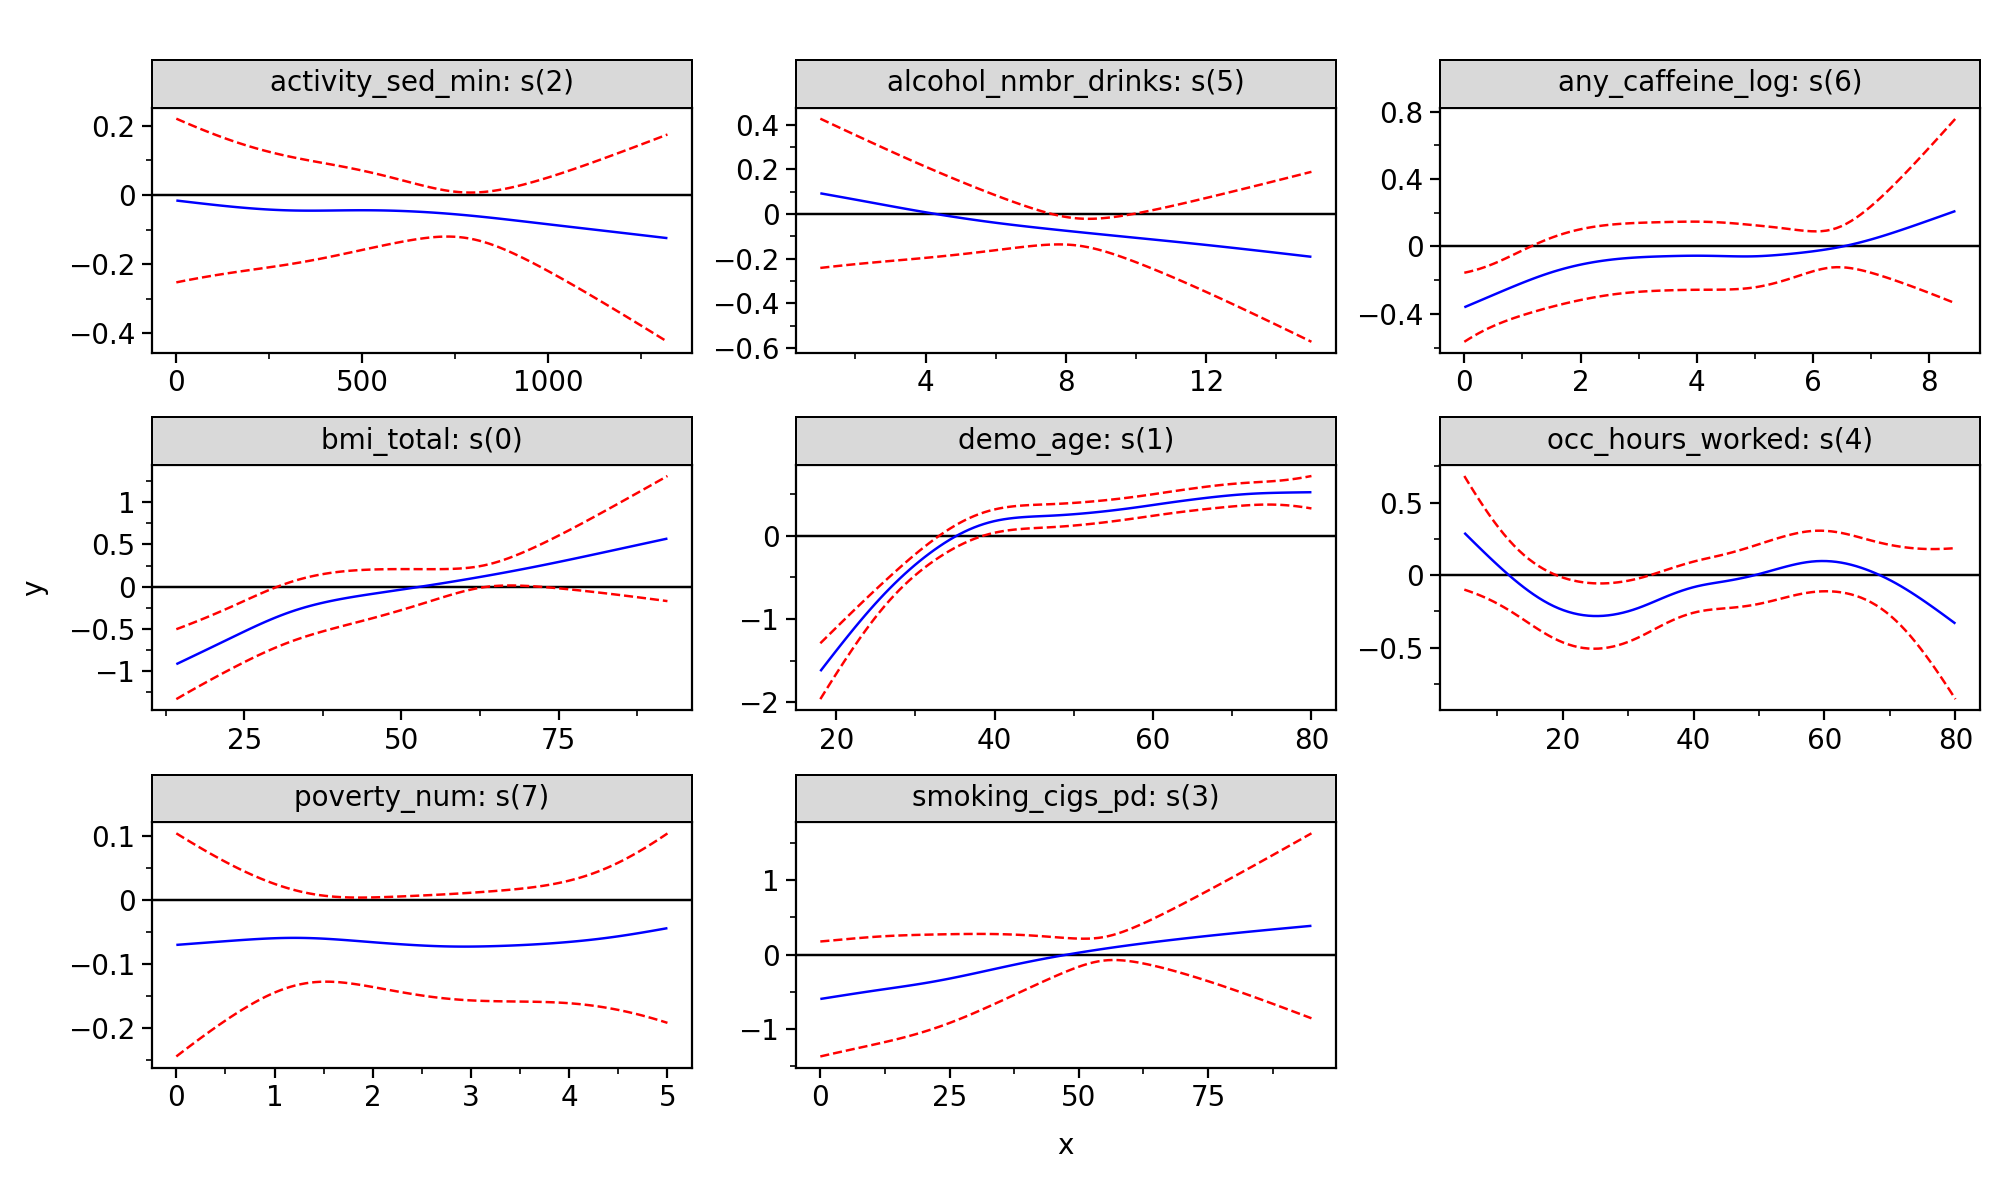

<Figure Size: (1000 x 600)>

In [41]:
num_terms = len(fitted_model.terms) - 1  # remove intercept
# fig, ax = plt.subplots(num_terms, ncols=1, sharey=False, sharex=False)

partial_dependence = []
for i, term in enumerate(fitted_model.terms):
    if term.isintercept:
        continue
    XX = fitted_model.generate_X_grid(term=i)
    y_vals, conf_limits = fitted_model.partial_dependence(i, XX, width=0.95)

    plot_df = pd.DataFrame(
        {
            "feature": f"{fit_data.columns[i]}: {term.__repr__()}",
            "x": XX[:, i],
            "y": y_vals,
            "low": conf_limits[:, 0],
            "high": conf_limits[:, 1],
        }
    )
    partial_dependence.append(plot_df)

partial_df = pd.concat(partial_dependence)
(
    ggplot(data=partial_df, mapping=aes(x="x", y="y"))
    + geom_hline(yintercept=0)
    + geom_line(color="blue")
    + facet_wrap("~feature", scales="free")
    + geom_line(aes(y="high"), color="red", linetype="--")
    + geom_line(aes(y="low"), color="red", linetype="--")
    + theme_matplotlib()
    + theme(figure_size=(10, 6))
)


In [ ]:
ggplot(data=fit_data, mapping=aes(x="age", y="alcohol_nmbr_dr"))